<a href="https://colab.research.google.com/github/mursaleen-sengr/Rumor-Classification-/blob/main/final_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers
!pip install torch

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
!pip install datasets
!pip install transformers[torch] accelerate -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 10.0 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 6.0 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import DataCollatorWithPadding
from datasets import Dataset, load_metric



In [ ]:
# Load your dataset
df = pd.read_excel("DATASET_R1.xlsx")
df.head()


,ID,Description,#Tweets,Date_time_creation_account,Language,#Followers,#Friends,Date&Time,#Favorite,#Retweet,Another Tweet Inside,Source,Tweet ID,Retweet ID,Quote ID,Reply ID,Frequency of tweet occurrences,State of Tweet
0,2752994783,// Kirby// they/them // 20 // ENG: ok // FR: ok,2822,"2014 , Aug , 28 , 01:49:22",en,34,68,"['2017', 'Dec', '15', '15:42:41']",0,250,0,iPhone,941695012122910720,940977667104477185,Not a quote,NaN,213.0,r
1,21571977,Follow us for the latest headlines across the ...,3085,"2009 , Feb , 22 , 15:32:48",en,21083,31,"['2017', 'Dec', '15', '15:37:51']",0,0,0,iPhone,941693798056280064,Not a Retweet,Not a quote,NaN,1,n
2,3382041618,Growing minds... Changing lives.,46,"2015 , Aug , 29 , 13:45:01",en,82,68,"['2017', 'Dec', '15', '15:37:37']",0,0,0,iPhone,941693735678758912,Not a Retweet,Not a quote,NaN,1,n
3,348478568,NaN,2007,"2011 , Aug , 04 , 14:08:52",en,26,270,"['2017', 'Dec', '15', '15:37:16']",0,0,0,Client,941693648634372097,Not a Retweet,Not a quote,NaN,1,n
4,724097168152367104,One does not simply un-FeelTheBern! 🔥,13050,"2016 , Apr , 24 , 04:46:32",en,166,287,"['2017', 'Dec', '15', '15:35:34']",0,151,0,iPhone,941693221704536064,941044904742006786,Not a quote,NaN,140.0,a


In [ ]:
# Check for null values and remove them
df.dropna(inplace=True)

# Convert DataFrame to HuggingFace Dataset
dataset = Dataset.from_pandas(df)



In [ ]:
df.isnull().sum()

ID                                0
Description                       0
#Tweets                           0
Date_time_creation_account        0
Language                          0
#Followers                        0
#Friends                          0
Date&Time                         0
#Favorite                         0
#Retweet                          0
Another Tweet Inside              0
Source                            0
Tweet ID                          0
Retweet ID                        0
Quote ID                          0
Reply ID                          0
Frequency of tweet occurrences    0
State of Tweet                    0
dtype: int64

In [ ]:

# Encode labels
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['State of Tweet'])

# Split the dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df['Description'].tolist(), df['label'].tolist(), test_size=0.2, random_state=42
)

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Tokenize the texts
train_encodings = tokenizer(train_texts, truncation=True, padding=True)
val_encodings = tokenizer(val_texts, truncation=True, padding=True)

# Convert to datasets
train_dataset = Dataset.from_dict({'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask'], 'labels': train_labels})
val_dataset = Dataset.from_dict({'input_ids': val_encodings['input_ids'], 'attention_mask': val_encodings['attention_mask'], 'labels': val_labels})


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir='./results',          # output directory
    eval_strategy="epoch",           # evaluate each `epoch`
    per_device_train_batch_size=16,  # batch size for training
    per_device_eval_batch_size=16,   # batch size for evaluation
    num_train_epochs=3,              # number of training epochs
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
    logging_steps=10,
)

# Data collator for dynamic padding
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Load metric for evaluation
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    return {'accuracy': accuracy, 'f1': f1}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

<ipython-input-9-3bbb87e5f3fa>:22: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:759: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.2/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [ ]:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.578000,0.463090,0.896552,0.847649
2,0.527300,0.440542,0.896552,0.847649
3,0.402900,0.461071,0.908046,0.872522


TrainOutput(global_step=66, training_loss=0.4927812959208633, metrics={'train_runtime': 18.3982, 'train_samples_per_second': 56.256, 'train_steps_per_second': 3.587, 'total_flos': 38295679556160.0, 'train_loss': 0.4927812959208633, 'epoch': 3.0})

In [ ]:
results = trainer.evaluate()
print(results)


{'eval_loss': 0.4610714614391327, 'eval_accuracy': 0.9080459770114943, 'eval_f1': 0.8725219271897152, 'eval_runtime': 0.3754, 'eval_samples_per_second': 231.758, 'eval_steps_per_second': 15.983, 'epoch': 3.0}


In [ ]:
# Predict on validation set
predictions = trainer.predict(val_dataset)

# Get predicted labels
preds = np.argmax(predictions.predictions, axis=-1)

# Calculate accuracy and F1 score
accuracy = accuracy_score(val_labels, preds)
f1 = f1_score(val_labels, preds, average='weighted')

print(f'Validation Accuracy: {accuracy}')
print(f'Validation F1 Score: {f1}')


Validation Accuracy: 0.9080459770114943
Validation F1 Score: 0.8725219271897152


In [ ]:
model.save_pretrained('bert_model')
tokenizer.save_pretrained('bert_tokenizer')


('bert_tokenizer/tokenizer_config.json',
 'bert_tokenizer/special_tokens_map.json',
 'bert_tokenizer/vocab.txt',
 'bert_tokenizer/added_tokens.json')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

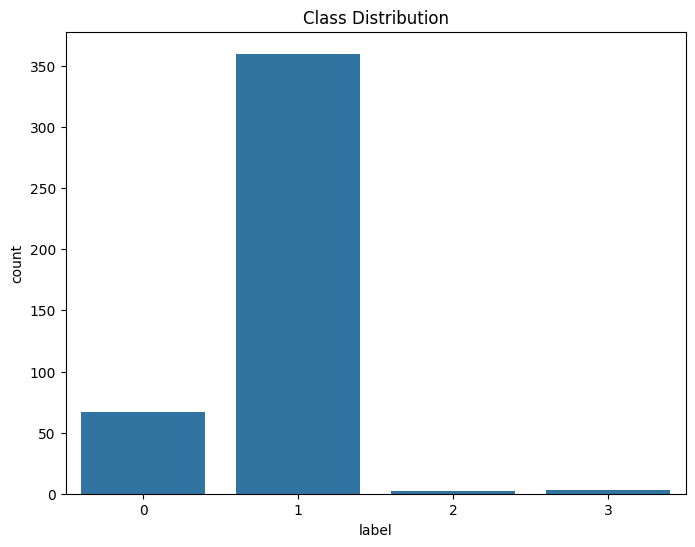

In [ ]:
# Check class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df)
plt.title('Class Distribution')
plt.show()

In [ ]:
# Get training logs
train_logs = trainer.state.log_history

# Initialize lists for metrics
epochs = []
train_loss = []
eval_loss = []
eval_accuracy = []
eval_f1 = []

# Extract the relevant metrics for plotting
for log in train_logs:
    if 'epoch' in log:
        epochs.append(log['epoch'])
    if 'loss' in log:
        train_loss.append(log['loss'])
    if 'eval_loss' in log:
        eval_loss.append(log['eval_loss'])
    if 'eval_accuracy' in log:
        eval_accuracy.append(log['eval_accuracy'])
    if 'eval_f1' in log:
        eval_f1.append(log['eval_f1'])

# Ensure all lists are the same length
min_len = min(len(epochs), len(train_loss), len(eval_loss), len(eval_accuracy), len(eval_f1))
epochs = epochs[:min_len]
train_loss = train_loss[:min_len]
eval_loss = eval_loss[:min_len]
eval_accuracy = eval_accuracy[:min_len]
eval_f1 = eval_f1[:min_len]


In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

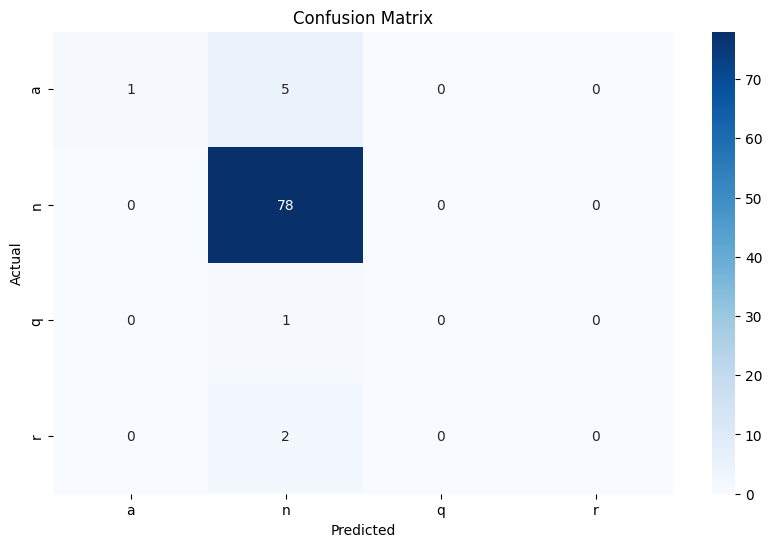

In [ ]:
# Confusion matrix
y_pred = trainer.predict(val_dataset).predictions.argmax(axis=-1)
conf_matrix = confusion_matrix(val_labels, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('confusion_matrix.png')
plt.show()


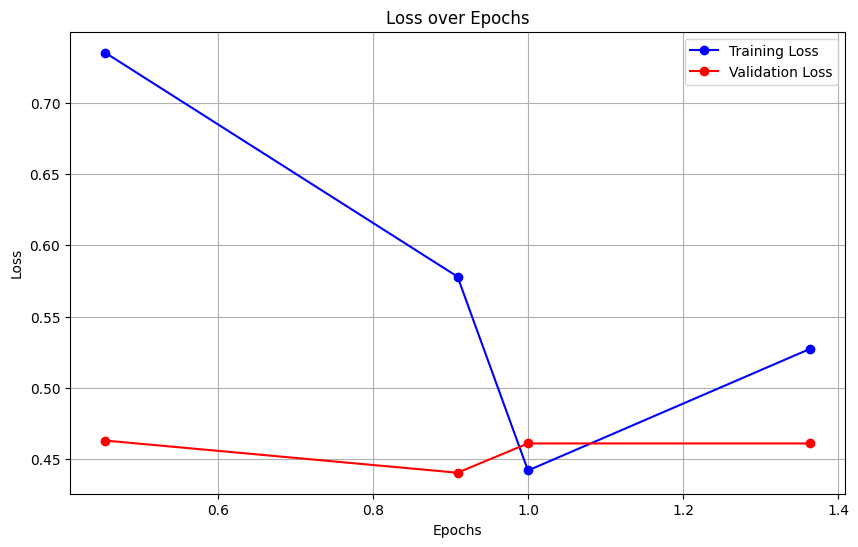

In [ ]:
# Plot loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, marker='o', linestyle='-', color='b', label='Training Loss')
plt.plot(epochs, eval_loss, marker='o', linestyle='-', color='r', label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('loss_plot.png')
plt.show()



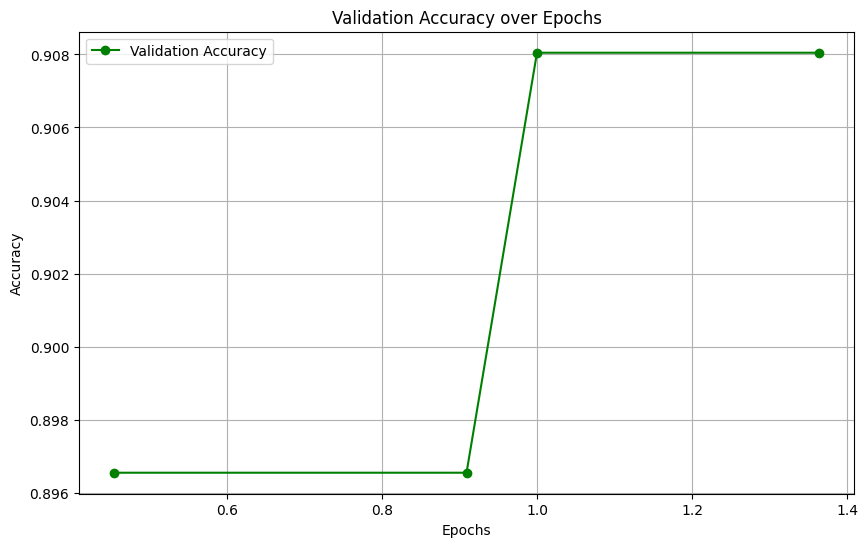

In [ ]:

# Plot accuracy over epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, eval_accuracy, marker='o', linestyle='-', color='g', label='Validation Accuracy')
plt.title('Validation Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('accuracy_plot.png')
plt.show()

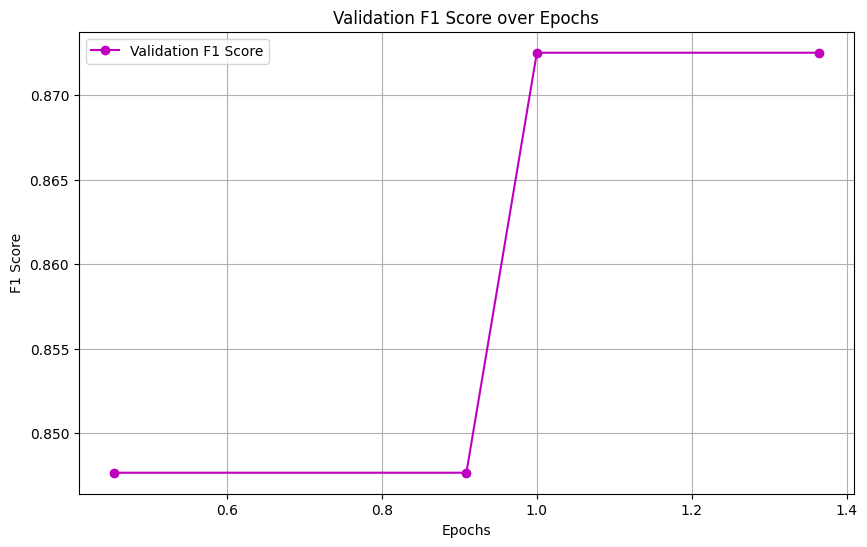

In [ ]:
# Plot F1 score over epochs
plt.figure(figsize=(10, 6))
plt.plot(epochs, eval_f1, marker='o', linestyle='-', color='m', label='Validation F1 Score')
plt.title('Validation F1 Score over Epochs')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.legend()
plt.grid(True)
plt.savefig('f1_score_plot.png')
plt.show()


In [ ]:
!pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 57.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.3 MB/s eta 0:00:00


In [ ]:
with open('app.py', 'w') as f:
    f.write("""
import streamlit as st
from transformers import BertTokenizer, BertForSequenceClassification
import torch

@st.cache(allow_output_mutation=True)
def load_model():
    model = BertForSequenceClassification.from_pretrained('bert_model')
    tokenizer = BertTokenizer.from_pretrained('bert_tokenizer')
    return model, tokenizer

model, tokenizer = load_model()

st.title("Tweet State Classification")
user_input = st.text_area("Enter the tweet description")

if st.button("Classify"):
    inputs = tokenizer(user_input, return_tensors="pt", truncation=True, padding=True)
    outputs = model(**inputs)
    predictions = torch.argmax(outputs.logits, dim=-1).item()
    st.write(f"Predicted State: {predictions}")
""")


In [ ]:
! wget -q -O - ipv4.icanhazip.com

35.233.138.80


In [ ]:
! streamlit run app.py & npx localtunnel --port 8501




  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.233.138.80:8501

npx: installed 22 in 3.809s
your url is: https://swift-seals-hear.loca.lt
2024-06-11 18:15:16.316 `st.cache` is deprecated. Please use one of Streamlit's new caching commands,
`st.cache_data` or `st.cache_resource`.

More information [in our docs](https://docs.streamlit.io/library/advanced-features/caching).
2024-06-11 18:16:17.419 `st.cache` is deprecated. Please use one of Streamlit's new caching commands,
`st.cache_data` or `st.cache_resource`.

More information [in our docs](https://docs.streamlit.io/library/advanced-features/caching).
  Stopping...
^C
